# Master notebook

## Imports

In [2]:
import xarray as xr
import glob
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

from google.cloud import storage
import gcsfs
import zarr

import xskillscore as xs
import pandas as pd

import os

import re
import skill_metrics as sm

import matplotlib.lines as mlines

## SYNOP processing

In [3]:
# Define a function to create the file pattern for the desired time points
def generate_file_patterns(base_path, start_date, end_date, hours):
    file_patterns = []
    current_date = start_date
    while current_date <= end_date:
        for hour in hours:
            # Generate the pattern for the files at 00 minutes
            pattern = f"{base_path}/{current_date.year}/{current_date.month:02d}/{current_date.day:02d}/{hour:02d}/KMDS__OPER_P___10M_OBS_L2_{current_date.year}{current_date.month:02d}{current_date.day:02d}{hour:02d}00.nc"
            file_patterns.append(pattern)
        # Move to the next day
        current_date += datetime.timedelta(days=1)
    return file_patterns

# Define the base path and desired time points
base_path = "/net/shared/student-projects/koenr/knmi_synop"
start_date = datetime.date(2022, 1, 12)  # Start from January 12th
end_date = datetime.date(2022, 12, 31)   # Until the end of the year
hours = [0, 6, 12, 18]  # Every 6 hours

# Generate the list of file patterns
file_patterns = generate_file_patterns(base_path, start_date, end_date, hours)

# Initialize an empty list to store the matching files
file_list = []

# Use glob to find all matching files
for pattern in file_patterns:
    file_list.extend(glob.glob(pattern))

# Sort the file list to ensure proper ordering
file_list = sorted(file_list)

# Open and combine the datasets
ds = xr.open_mfdataset(file_list, combine='by_coords')

# Write to file
ds.to_netcdf('/home/koenr/thesis_code/Graphcast/SYNOP_2022.nc')

ds

# This block takes 40 minutes to run

#### Plotting the stations and graphcast/HRES grid

56
53
50
50


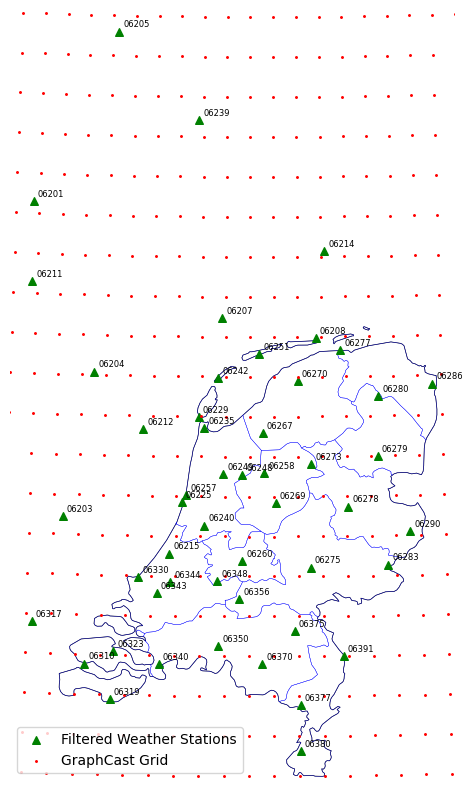

In [4]:
synop = xr.open_dataset('/home/koenr/thesis_code/SYNOP_2022.nc')

# Assuming synop` is your dataset containing lat/lon information
station_lats =synop['lat'].isel(time=100).values  # Assuming time doesn't affect lat/lon
station_lons =synop['lon'].isel(time=100).values  # Select first time step to ensure scalars
station_names =synop['station'].values  # Station identifiers

print(len(station_lats))

# Remove any stations where lat or lon is NaN
valid_mask = ~np.isnan(station_lats) & ~np.isnan(station_lons)
station_lats = station_lats[valid_mask]
station_lons = station_lons[valid_mask]
station_names = station_names[valid_mask]

print(len(station_lats))

# Define the latitude and longitude boundaries
lat_min = 40  # Southern boundary
lat_max = 70  # Northern boundary
lon_min = -5   # Western boundary (includes North Sea offshore locations)
lon_max = 16   # Eastern boundary

# Filter the stations based on the lat/lon boundaries
valid_bounds_mask = (
    (station_lats >= lat_min) & (station_lats <= lat_max) &
    (station_lons >= lon_min) & (station_lons <= lon_max)
)
station_lats = station_lats[valid_bounds_mask]
station_lons = station_lons[valid_bounds_mask]
station_names = station_names[valid_bounds_mask]

print(len(station_lats))

# Create a GeoDataFrame with the filtered station locations
gdf_stations = gpd.GeoDataFrame(
    {'Station': station_names},
    geometry=[Point(lon, lat) for lon, lat in zip(station_lons, station_lats)],
    crs="EPSG:4326"  # Initial projection is WGS84
)

print(len(gdf_stations))

# Load the shapefile for country boundaries and reproject to EPSG:28992
world = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
netherlands = world[(world.SOVEREIGNT == "Netherlands") & (world.CONTINENT == "Europe")]
netherlands = netherlands.to_crs(epsg=28992)

# Load the shapefile for provinces and reproject to EPSG:28992
provinces = gpd.read_file("/home/koenr/thesis_code/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
provinces = provinces.to_crs(epsg=28992)

# Filter for the Netherlands using the 'ADM1_CODE' that starts with 'NLD'
netherlands_provinces = provinces[
    provinces['adm1_code'].str.startswith('NLD') &
    (provinces['geometry'].centroid.y > 300000) &  # Adjusted latitude filter for EPSG:28992
    (provinces['geometry'].centroid.y < 620000) &  # Upper latitude bound
    (provinces['geometry'].centroid.x > -100000) &  # Adjusted longitude filter for EPSG:28992
    (provinces['geometry'].centroid.x < 300000)  # Upper longitude bound
]

# Create grid points at 0.25 degree intervals in WGS84
lat_points = np.arange(lat_min, lat_max, 0.25)
lon_points = np.arange(lon_min, lon_max, 0.25)
grid_points = np.array(np.meshgrid(lon_points, lat_points)).T.reshape(-1, 2)

# Create a GeoDataFrame for the grid points in WGS84
gdf_grid = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in grid_points],
    crs="EPSG:4326"  # WGS84 projection
)

# Reproject the grid points to the Netherlands-specific projection (EPSG:28992)
gdf_grid = gdf_grid.to_crs(epsg=28992)

# Reproject the filtered stations to the Netherlands-specific projection (EPSG:28992)
gdf_stations = gdf_stations.to_crs(epsg=28992)

# Plot the Netherlands with province boundaries
fig, ax = plt.subplots(figsize=(8, 10))

# Plot the Netherlands country boundary
netherlands.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the Netherlands provinces boundaries
netherlands_provinces.plot(ax=ax, color='none', edgecolor='blue', linewidth=0.25)

# Plot the filtered weather station locations
gdf_stations.plot(ax=ax, color='green', marker='^', markersize=30, label='Filtered Weather Stations')

# Plot the grid points
gdf_grid.plot(ax=ax, color='red', marker='.', markersize=5, label='GraphCast Grid')

# Annotate the weather stations (optional)
for idx, row in gdf_stations.iterrows():
    ax.annotate(row["Station"], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=6)

# Set limits based on the exact extent of the Netherlands provinces, with some padding
padding = 15000  # Meter padding around the extents (since EPSG:28992 is in meters)
bounds = gdf_stations.total_bounds
ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
ax.set_ylim(bounds[1] - padding - 5000, bounds[3] + padding)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.legend()
# plt.savefig('Filtered_SYNOP_stations_with_grid_offshore.png')
plt.show()

### SYNOP processing

In [36]:
synop = xr.open_dataset('SYNOP_2022_full.nc')
results = xr.open_dataset('results_2022_ws.nc')

# Function to convert wind speed and direction into u and v components
def wind_components(speed, direction):
    """
    Convert wind speed and direction into u and v components.
    speed: Wind speed (m/s)
    direction: Wind direction (degrees)
    Returns: u, v components of the wind (m/s)
    """
    rad = np.deg2rad(direction)
    u = speed * np.sin(rad) * -1
    v = speed * np.cos(rad) * -1
    return u, v

# Extract and rename variables
ds_renamed = synop.rename({
    'ta': '2m_temperature_synop',                        # 2m temperature
    'pp': 'mean_sea_level_pressure_synop',               # Mean sea level pressure
    'ff': 'wind_speed_synop',                            # 10m wind speed, to be converted
    'dd': 'wind_direction_synop',                        # 10m wind direction, to be converted
    'R6H': 'total_precipitation_6hr_synop',              # Rainfall in last 6 Hours
    # Add other variable mappings if necessary
})

# Calculate wind components from speed and direction
u_component, v_component = wind_components(ds_renamed['wind_speed_synop'], ds_renamed['wind_direction_synop'])

# Create DataArray objects for u and v components with appropriate coordinates and dimensions
u_dataarray = xr.DataArray(
    u_component,
    coords={'station': ds_renamed['station'], 'time': ds_renamed['time']},
    dims=['station', 'time'],
    name='10m_u_component_of_wind_synop'
)

v_dataarray = xr.DataArray(
    v_component,
    coords={'station': ds_renamed['station'], 'time': ds_renamed['time']},
    dims=['station', 'time'],
    name='10m_v_component_of_wind_synop'
)

# Add the wind components to the dataset
ds_renamed['10m_u_component_of_wind_synop'] = u_dataarray
ds_renamed['10m_v_component_of_wind_synop'] = v_dataarray

# Drop the original wind speed and direction since they're now represented as u and v components
ds_renamed = ds_renamed.drop_vars(['wind_speed_synop', 'wind_direction_synop'])

# Define latitude and longitude boundaries for mainland Netherlands and offshore North Sea
lat_min = 45  # Southern boundary
lat_max = 60  # Northern boundary
lon_min = 1   # Western boundary (includes North Sea offshore locations)
lon_max = 9   # Eastern boundary

# Filter the dataset based on the latitude and longitude boundaries
ds_filtered = ds_renamed.where(
    (ds_renamed['lat'] >= lat_min) &
    (ds_renamed['lat'] <= lat_max) &
    (ds_renamed['lon'] >= lon_min) &
    (ds_renamed['lon'] <= lon_max),
    drop=True
)

# Assuming `ds_filtered` is your dataset containing lat/lon information
# Select latitude and longitude at the first timestep
station_lats = ds_filtered['lat'].isel(time=0).values  # Select first timestep
station_lons = ds_filtered['lon'].isel(time=0).values  # Select first timestep
station_names = ds_filtered['station'].values  # Station identifiers

# Print the number of stations before filtering
print(f"Number of stations before filtering: {len(station_lats)}")

# Create a mask for valid stations (where lat and lon are not NaN)
valid_mask = ~np.isnan(station_lats) & ~np.isnan(station_lons)

# Filter stations based on the valid mask
station_lats = station_lats[valid_mask]
station_lons = station_lons[valid_mask]
station_names = station_names[valid_mask]

# Apply the valid mask to the dataset to drop stations with NaN lat/lon
ds_filtered = ds_filtered.sel(station=valid_mask)

# Print the number of stations after filtering
print(f"Number of stations after filtering: {len(station_lats)}")

# Keep only the specified variables
synop = ds_filtered[[  'stationname',
                            'height',
                            'lat',
                            'lon',
                            '2m_temperature_synop', 
                            'mean_sea_level_pressure_synop', 
                            '10m_u_component_of_wind_synop', 
                            '10m_v_component_of_wind_synop', 
                            'total_precipitation_6hr_synop']]

# List of variables to add from synop
variables_to_add = [
    '2m_temperature_synop',
    'mean_sea_level_pressure_synop',
    '10m_v_component_of_wind_synop',
    '10m_u_component_of_wind_synop',
    'total_precipitation_6hr_synop'
]

# Calculate valid_time for the entire forecast dataset
valid_time = results['time'] + results['prediction_timedelta']

# Align synop data with hres_for_interp valid_time
aligned_synop_data = synop.sel(time=valid_time, method='nearest')

# Create a new dataset to hold the '_synop' variables
new_vars = {}
for var_name in variables_to_add:
    new_var_name = var_name
    new_vars[new_var_name] = aligned_synop_data[var_name].broadcast_like(results['2m_temperature_hres'])

# Create a new dataset from the new_vars dictionary
synop_ds = xr.Dataset(new_vars)

# synop = synop_ds.drop_sel(station=['06205', '06239', '06252', '06391'])

# # Display the resulting dataset
# synop.to_netcdf('synop_2022.nc')

synop_ds


Number of stations before filtering: 53
Number of stations after filtering: 50


<xarray.Dataset> Size: 11MB
Dimensions:                        (prediction_timedelta: 16, time: 354,
                                    station: 50)
Coordinates:
  * prediction_timedelta           (prediction_timedelta) timedelta64[ns] 128B ...
  * time                           (time) datetime64[ns] 3kB 2022-01-12 ... 2...
  * station                        (station) <U5 1kB '06201' '06203' ... '06391'
Data variables:
    2m_temperature_synop           (time, prediction_timedelta, station) float64 2MB ...
    mean_sea_level_pressure_synop  (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_synop  (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_synop  (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_synop  (time, prediction_timedelta, station) float64 2MB ...

## HRES Processing

In [2]:
# Accessing weatherbench data
fs = gcsfs.GCSFileSystem(anon=True)  # Use anon=True for public data
store = gcsfs.GCSMap(root='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr', gcs=fs, check=False)
hres_for = xr.open_zarr(store, consolidated=True)

# # Renaming coordinates
# hres_for = hres_for.rename({'latitude': 'lat', 'longitude': 'lon'})

# # Slicing the data for the variables required
# hres_for = hres_for[[  
#                                 # 'geopotential_at_surface',
#                                 # 'land_sea_mask',                 
#                                 '2m_temperature',                
#                                 'mean_sea_level_pressure',       
#                                 '10m_v_component_of_wind',       
#                                 '10m_u_component_of_wind',       
#                                 'total_precipitation_6hr',       
#                                 # 'toa_incident_solar_radiation',  ----> to fix  
#                                 # 'temperature',                   
#                                 # 'geopotential',                  
#                                 # 'u_component_of_wind',           
#                                 # 'v_component_of_wind',          
#                                 # 'vertical_velocity',             
#                                 # 'specific_humidity'
#                                 ]]

# # Slice for 2022 and 4 days ahead
# hres_for = hres_for.sel(time='2022').isel(prediction_timedelta=range(1,17))  

# # Slice for 1 forecast per day
# hres_for = hres_for.sel(time=hres_for['time'].dt.hour == 0)

# # Slice for dates in SYNOP (2022-01-12 onwards)
# hres_for = hres_for.sel(time=slice( '2022-01-12','2022-12-31T00'))

# # Unit conversions to match synop
# hres_for['2m_temperature'] = hres_for['2m_temperature'] - 273.15
# hres_for['mean_sea_level_pressure'] = hres_for['mean_sea_level_pressure'] / 100

# # Rename variables to inlcude HRES specification
# hres_for = hres_for.rename_vars({
#     '2m_temperature': '2m_temperature_hres',                        # 2m temperature
#     'mean_sea_level_pressure': 'mean_sea_level_pressure_hres',               # Mean sea level pressure
#     '10m_v_component_of_wind': '10m_v_component_of_wind_hres',                            # 10m wind speed, to be converted
#     '10m_u_component_of_wind': '10m_u_component_of_wind_hres',                        # 10m wind direction, to be converted
#     'total_precipitation_6hr': 'total_precipitation_6hr_hres',              # Rainfall in last 6 Hours
#     # Add other variable mappings if necessary
# })

# Verify the updated dataset
hres_for

<xarray.Dataset> Size: 87TB
Dimensions:                   (time: 5134, prediction_timedelta: 41,
                               latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * latitude                  (latitude) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                 (longitude) float32 6kB 0.0 0.25 ... 359.5 359.8
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 328B 00:...
  * time                      (time) datetime64[ns] 41kB 2016-01-01 ... 2023-...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, latitude, longitude) float32 11TB dask.array<chunksize=(1, 1, 13, 721, 1440), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, latitude, longitude) float32 874GB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, latitude, longitude) float32 11TB dask.array<chunksize=(1, 1, 13, 721, 1440), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, latitude, longitude) float32 11TB dask.array<chunksize=(1, 1, 13, 721, 1440), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, latitude, longitude) float32 11TB dask.array<chunksize=(1, 1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, latitude, longitude) float32 11TB dask.array<chunksize=(1, 1, 13, 721, 1440), meta=np.ndarray>

### HRES loading and slicing

In [18]:
slicing_check = hres_for.sel(lat=slice(12, 18), lon=slice(291.5, 297))
slicing_check

<xarray.Dataset> Size: 65MB
Dimensions:                       (time: 354, prediction_timedelta: 16,
                                   lat: 25, lon: 23)
Coordinates:
  * lat                           (lat) float32 100B 12.0 12.25 ... 17.75 18.0
  * lon                           (lon) float32 92B 291.5 291.8 ... 296.8 297.0
  * prediction_timedelta          (prediction_timedelta) timedelta64[ns] 128B ...
  * time                          (time) datetime64[ns] 3kB 2022-01-12 ... 20...
Data variables:
    2m_temperature_hres           (time, prediction_timedelta, lat, lon) float32 13MB dask.array<chunksize=(1, 1, 25, 23), meta=np.ndarray>
    mean_sea_level_pressure_hres  (time, prediction_timedelta, lat, lon) float32 13MB dask.array<chunksize=(1, 1, 25, 23), meta=np.ndarray>
    10m_v_component_of_wind_hres  (time, prediction_timedelta, lat, lon) float32 13MB dask.array<chunksize=(1, 1, 25, 23), meta=np.ndarray>
    10m_u_component_of_wind_hres  (time, prediction_timedelta, lat, lon) float32 13MB dask.array<chunksize=(1, 1, 25, 23), meta=np.ndarray>
    total_precipitation_6hr_hres  (time, prediction_timedelta, lat, lon) float32 13MB dask.array<chunksize=(1, 1, 25, 23), meta=np.ndarray>

### HRES interpolating to station locations

In [7]:
# Extract unique station location data
station_locations = synop[['lat', 'lon']].isel(time=0).to_dataframe()

# # Remove any rows with missing data
# station_locations = station_locations.dropna()

# Reset index to maintain station codes as part of the DataFrame
station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
hres_for_interp = hres_for.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
hres_for_interp = hres_for_interp.assign_coords(station=("station", station_locations['station'].values))

# # Add time dimension for merging
hres_for_interp = hres_for_interp.assign_coords(valid_time=hres_for_interp['time'] + hres_for_interp['prediction_timedelta'])

# Display the interpolated dataset
hres_for_interp

### HRES analysis processing

In [2]:
# Accessing weatherbench data
fs = gcsfs.GCSFileSystem(anon=True)  # Use anon=True for public data
store = gcsfs.GCSMap(root='gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr', gcs=fs, check=False)
hres_analysis = xr.open_zarr(store, consolidated=True)

# Renaming coordinates
hres_analysis = hres_analysis.rename({'latitude': 'lat', 'longitude': 'lon'})

# Slicing the data for the variables required
hres_analysis = hres_analysis[[  
                                # 'geopotential_at_surface',
                                # 'land_sea_mask',                 
                                '2m_temperature',                
                                'mean_sea_level_pressure',       
                                '10m_v_component_of_wind',       
                                '10m_u_component_of_wind',       
                                'total_precipitation_6hr',       
                                # 'toa_incident_solar_radiation',  ----> to fix  
                                # 'temperature',                   
                                # 'geopotential',                  
                                # 'u_component_of_wind',           
                                # 'v_component_of_wind',          
                                # 'vertical_velocity',             
                                # 'specific_humidity'
                                ]]

# # Slice for 1 forecast per day
# hres_analysis = hres_analysis.sel(time=hres_analysis['time'].dt.hour == 0)

# Slice for dates in SYNOP (2022-01-12 onwards)
hres_analysis = hres_analysis.sel(time=slice( '2022-01-12','2022-12-31T00'))

# Unit conversions to match synop
hres_analysis['2m_temperature'] = hres_analysis['2m_temperature'] - 273.15
hres_analysis['mean_sea_level_pressure'] = hres_analysis['mean_sea_level_pressure'] / 100

# Rename variables to inlcude HRES specification
hres_analysis = hres_analysis.rename_vars({
    '2m_temperature': '2m_temperature_analysis',                        # 2m temperature
    'mean_sea_level_pressure': 'mean_sea_level_pressure_analysis',               # Mean sea level pressure
    '10m_v_component_of_wind': '10m_v_component_of_wind_analysis',                            # 10m wind speed, to be converted
    '10m_u_component_of_wind': '10m_u_component_of_wind_analysis',                        # 10m wind direction, to be converted
    'total_precipitation_6hr': 'total_precipitation_6hr_analysis',              # Rainfall in last 6 Hours
    # Add other variable mappings if necessary
})

# Verify the updated dataset
hres_analysis

<xarray.Dataset> Size: 29GB
Dimensions:                           (time: 1413, lat: 721, lon: 1440)
Coordinates:
  * lat                               (lat) float32 3kB -90.0 -89.75 ... 90.0
  * lon                               (lon) float32 6kB 0.0 0.25 ... 359.5 359.8
  * time                              (time) datetime64[ns] 11kB 2022-01-12 ....
Data variables:
    2m_temperature_analysis           (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mean_sea_level_pressure_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    total_precipitation_6hr_analysis  (time, lat, lon) float32 6GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [5]:
hres_analysis['total_precipitation_6hr_analysis'].isel(lat=100,lon=100,time=100).compute()

<xarray.DataArray 'total_precipitation_6hr_analysis' ()> Size: 4B
array(0., dtype=float32)
Coordinates:
    lat      float32 4B -65.0
    lon      float32 4B 25.0
    time     datetime64[ns] 8B 2022-02-06
Attributes:
    long_name:      Total precipitation
    short_name:     tp
    standard_name:  unknown
    units:          m

### HRES analysis interpolating

In [3]:
# Extract unique station location data
station_locations = synop[['lat', 'lon']].isel(time=0).to_dataframe()

# # Remove any rows with missing data
# station_locations = station_locations.dropna()

# Reset index to maintain station codes as part of the DataFrame
station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
hres_analysis_interp = hres_analysis.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
hres_analysis_interp = hres_analysis_interp.assign_coords(station=("station", station_locations['station'].values))

# # # Add time dimension for merging
# hres_anlaysis_interp = hres_anlaysis_interp.assign_coords(valid_time=hres_anlaysis_interp['time'] + hres_anlaysis_interp['prediction_timedelta'])

# Display the interpolated dataset
hres_analysis_interp

NameError: name 'synop' is not defined

## Graphcast processing

### Loading and concatenating graphcast forecasts

In [ ]:
# Define the date range
start_date = pd.to_datetime("2022-01-12")
end_date = pd.to_datetime("2022-12-31")
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Define the file naming pattern
file_pattern = "gc_fc/gc_nl_{date}_16.nc"

# List to hold each dataset
datasets = []

# Loop through each date and load the corresponding NetCDF file
for date in dates:
    file_name = file_pattern.format(date=date.strftime("%Y-%m-%d"))
    if os.path.exists(file_name):
        ds = xr.open_dataset(file_name)
        datasets.append(ds)
    else:
        print(f"File not found: {file_name}")

# Combine all datasets along a new time dimension
gc = xr.concat(datasets, dim="time")

# Slicing the data for the variables required
gc = gc[[  
                                # 'geopotential_at_surface',
                                # 'land_sea_mask',                 
                                '2m_temperature',                
                                'mean_sea_level_pressure',       
                                '10m_v_component_of_wind',       
                                '10m_u_component_of_wind',       
                                'total_precipitation_6hr',       
                                # 'toa_incident_solar_radiation', 
                                # 'temperature',                   
                                # 'geopotential',                  
                                # 'u_component_of_wind',           
                                # 'v_component_of_wind',          
                                # 'vertical_velocity',             
                                # 'specific_humidity'
                                ]]

# Unit conversions to match synop
gc['2m_temperature'] = gc['2m_temperature'] - 273.15
gc['mean_sea_level_pressure'] = gc['mean_sea_level_pressure'] / 100

# Rename variables to inlcude gc specification
gc = gc.rename_vars({
    '2m_temperature': '2m_temperature_gc',                        # 2m temperature
    'mean_sea_level_pressure': 'mean_sea_level_pressure_gc',               # Mean sea level pressure
    '10m_v_component_of_wind': '10m_v_component_of_wind_gc',                            # 10m wind speed, to be converted
    '10m_u_component_of_wind': '10m_u_component_of_wind_gc',                        # 10m wind direction, to be converted
    'total_precipitation_6hr': 'total_precipitation_6hr_gc',              # Rainfall in last 6 Hours
    # Add other variable mappings if necessary
})

# drop the batch dimension
gc = gc.squeeze('batch')

# save the dataset to a netcdf file
gc.to_netcdf('gc_2022.nc')

# Load the dataset from the saved file
gc = xr.open_dataset('gc_2022.nc')

# Verify the updated dataset
gc

### Processing graphcast

In [17]:
gc_2022 = xr.open_dataset('gc_2022.nc')
gc_2022['time'] = gc_2022['time']+ pd.Timedelta('6h')
gc_2022_shifted = gc_2022

### Interpolating the shifted graphcast

In [13]:
print(results.compute())

<xarray.Dataset> Size: 45MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 47)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 940B '06201' ... '06380'
    lat                               (station) float64 376B 54.33 ... 50.91
    lon                               (station) float64 376B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/30)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (tim

In [19]:
# open results dataset to find station locations
results = xr.open_dataset('results_2022_ws.nc')


# Extract latitudes and longitudes for all stations
station_names = results['station'].values   
latitudes = results['lat'].values
longitudes = results['lon'].values

# Combine lat and lon into a pandas DataFrame
station_locations = pd.DataFrame({'station': station_names, 'lat': latitudes, 'lon': longitudes})

station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
gc_interp = gc_2022_shifted.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
gc_interp = gc_interp.assign_coords(station=("station", station_locations['station'].values))

# # Add time dimension for merging
gc_shifted_interp = gc_interp.assign_coords(valid_time=gc_interp['time'] + gc_interp['prediction_timedelta'])

# Display the interpolated dataset
# gc_interp.sel(station='06201', time='2022-02-01',prediction_timedelta='12hr').compute()

gc_shifted_interp

<xarray.Dataset> Size: 11MB
Dimensions:                     (time: 354, prediction_timedelta: 16,
                                 station: 47)
Coordinates:
  * prediction_timedelta        (prediction_timedelta) timedelta64[ns] 128B 0...
  * time                        (time) datetime64[ns] 3kB 2022-01-12T06:00:00...
    lat                         (station) float64 376B 54.33 52.36 ... 50.91
    lon                         (station) float64 376B 2.936 3.342 ... 5.762
  * station                     (station) object 376B '06201' ... '06380'
    valid_time                  (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables:
    2m_temperature_gc           (time, prediction_timedelta, station) float64 2MB ...
    mean_sea_level_pressure_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_gc  (time, prediction_timedelta, station) float64 2MB ...

In [29]:
print(gc_2022['10m_u_component_of_wind_gc'].isel(lat=2,lon=2, time=100, prediction_timedelta=2).compute())
print(gc_2022_shifted['10m_u_component_of_wind_gc'].isel(lat=2,lon=2, time=100, prediction_timedelta=2).compute())

<xarray.DataArray '10m_u_component_of_wind_gc' ()> Size: 4B
array(-4.7421446, dtype=float32)
Coordinates:
    lat                   float32 4B 51.0
    lon                   float32 4B 2.75
    prediction_timedelta  timedelta64[ns] 8B 18:00:00
    time                  datetime64[ns] 8B 2022-04-22
<xarray.DataArray '10m_u_component_of_wind_gc' ()> Size: 4B
array(-4.7421446, dtype=float32)
Coordinates:
    lat                   float32 4B 51.0
    lon                   float32 4B 2.75
    prediction_timedelta  timedelta64[ns] 8B 18:00:00
    time                  datetime64[ns] 8B 2022-04-22T06:00:00


### Interpolating graphcast

In [25]:
# open gc_2022
gc_2022 = xr.open_dataset('gc_2022.nc')

# open results dataset to find station locations
results = xr.open_dataset('results_2022_ws.nc')


# Extract latitudes and longitudes for all stations
station_names = results['station'].values   
latitudes = results['lat'].values
longitudes = results['lon'].values

# Combine lat and lon into a pandas DataFrame
station_locations = pd.DataFrame({'station': station_names, 'lat': latitudes, 'lon': longitudes})

station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
gc_interp = gc_2022.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
gc_interp = gc_interp.assign_coords(station=("station", station_locations['station'].values))

# # Add time dimension for merging
gc_interp = gc_interp.assign_coords(valid_time=gc_interp['time'] + gc_interp['prediction_timedelta'])

# Display the interpolated dataset
# gc_interp.sel(station='06201', time='2022-02-01',prediction_timedelta='12hr').compute()

gc_interp

<xarray.Dataset> Size: 11MB
Dimensions:                     (time: 354, prediction_timedelta: 16,
                                 station: 47)
Coordinates:
  * prediction_timedelta        (prediction_timedelta) timedelta64[ns] 128B 0...
  * time                        (time) datetime64[ns] 3kB 2022-01-12 ... 2022...
    lat                         (station) float64 376B 54.33 52.36 ... 50.91
    lon                         (station) float64 376B 2.936 3.342 ... 5.762
  * station                     (station) object 376B '06201' ... '06380'
    valid_time                  (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables:
    2m_temperature_gc           (time, prediction_timedelta, station) float64 2MB ...
    mean_sea_level_pressure_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_gc  (time, prediction_timedelta, station) float64 2MB ...

## MESOGRASP Processing

### Loading and transforming mesograsp

## Combining HRES_for, HRES_analysis, GraphCast, MESO and SYNOP

### Adding SYNOP/HRES to results, HRES as format

In [12]:
# List of variables to add from synop
variables_to_add = [
    '2m_temperature_synop',
    'mean_sea_level_pressure_synop',
    '10m_v_component_of_wind_synop',
    '10m_u_component_of_wind_synop',
    'total_precipitation_6hr_synop'
]

# Calculate valid_time for the entire forecast dataset
valid_time = hres_for_interp['time'] + hres_for_interp['prediction_timedelta']

# Align synop data with hres_for_interp valid_time
aligned_synop_data = synop.sel(time=valid_time, method='nearest')

# Create a new dataset to hold the '_synop' variables
new_vars = {}
for var_name in variables_to_add:
    new_var_name = var_name
    new_vars[new_var_name] = aligned_synop_data[var_name].broadcast_like(hres_for_interp['2m_temperature_hres'])

# Create a new dataset from the new_vars dictionary
synop_ds = xr.Dataset(new_vars)

# Merge the new variables with the original forecast dataset
results = xr.merge([hres_for_interp, synop_ds])

# Now hres_for_interp contains the new '_synop' variables efficiently added
results

### Adding GraphCast to results

In [21]:
# remove existing gc variables
results = results.drop_vars([var for var in results if var.endswith('_gc')])

# List of variables to add from graphcast
variables_to_add = [
    '2m_temperature_gc',
    'mean_sea_level_pressure_gc',
    '10m_v_component_of_wind_gc',
    '10m_u_component_of_wind_gc',
    'total_precipitation_6hr_gc'
]

# Calculate valid_time for the entire forecast dataset
valid_time = results['valid_time']

# Align synop data with gc_interp valid_time
aligned_gc = gc_shifted_interp.sel(time=valid_time, method='nearest')

# attempting to shift graphcast 6 hours to the right
aligned_gc['time'] = aligned_gc['time'] + pd.Timedelta('6h')

# Create a new dataset to hold the '_gc' variables
new_vars = {}
for var_name in variables_to_add:
    new_var_name = var_name
    new_vars[new_var_name] = aligned_gc[var_name].broadcast_like(results['2m_temperature_hres'])

# Create a new dataset from the new_vars dictionary
gc_ds = xr.Dataset(new_vars)


# Merge the new variables with the original forecast dataset
results = xr.merge([results, gc_ds], compat='override')

# add wind speed
results['10m_wind_speed_gc'] = np.sqrt(results['10m_u_component_of_wind_gc']**2 + results['10m_v_component_of_wind_gc']**2)



# # Now hres_for_interp contains the new '_synop' variables efficiently added
# results.sel(station='06260', time='2022-02-01',prediction_timedelta='12hr').compute()

# drop the following stations from results '06205', '06239', '06320', '06321', '06391', '78871', '78873', '78990'
# results = results.drop_sel(station=['06205', '06239','06391'])

# compute the dataset and write to file
results.to_netcdf('results_2022_ws_gcshifted.nc')

results

<xarray.Dataset> Size: 45MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 47)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 940B '06201' ... '06380'
    lat                               (station) float64 376B 54.33 ... 50.91
    lon                               (station) float64 376B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/30)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 2MB ...
    ...                                ...
    2m_temperature_gc                 (time, prediction_timedelta, station) float64 2MB ...
    mean_sea_level_pressure_gc        (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_gc        (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_gc        (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_gc        (time, prediction_timedelta, station) float64 2MB ...
    10m_wind_speed_gc                 (time, prediction_timedelta, station) float64 2MB ...

In [5]:
results_unshifted = xr.open_dataset('results_2022_ws.nc')
#select all variables in the results dataset that end with _gc
results_gc = results_unshifted[[var for var in results_unshifted if var.endswith('_gc')]]

# results_gc['time'] = results_gc['time'] + pd.Timedelta('6h')
# results_gc['valid_time'] = results_gc['valid_time'] + pd.Timedelta('6h')
results_gc['time'] = results_gc['time'] + pd.Timedelta('6h')

# same allong the time dimension
# results_gc = results_gc.assign_coords(time=results['time'])

# results_gc

# # drop the non shifted variables from the results dataset
# results = results.drop_vars([var for var in results if var.endswith('_gc')])

# # add the shifted variables to the results dataset
# results_gc_shifted = xr.merge([results, results_gc], compat='override')

print(results_unshifted['2m_temperature_gc'].isel(station=8, time=100, prediction_timedelta=3).values)
print(results_gc['2m_temperature_gc'].isel(station=8, time=100, prediction_timedelta=3).values)

results_gc

9.54908501466117
9.54908501466117


<xarray.Dataset> Size: 13MB
Dimensions:                     (time: 354, prediction_timedelta: 16,
                                 station: 47)
Coordinates:
  * prediction_timedelta        (prediction_timedelta) timedelta64[ns] 128B 0...
  * time                        (time) datetime64[ns] 3kB 2022-01-12T06:00:00...
  * station                     (station) <U5 940B '06201' '06203' ... '06380'
    lat                         (station) float64 376B ...
    lon                         (station) float64 376B ...
    valid_time                  (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables:
    2m_temperature_gc           (time, prediction_timedelta, station) float64 2MB ...
    mean_sea_level_pressure_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_v_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_u_component_of_wind_gc  (time, prediction_timedelta, station) float64 2MB ...
    total_precipitation_6hr_gc  (time, prediction_timedelta, station) float64 2MB ...
    10m_wind_speed_gc           (time, prediction_timedelta, station) float64 2MB ...

In [75]:
results = xr.open_dataset('results_2022_ws.nc')
results_gc_shifted = xr.open_dataset('results_2022_ws_gcshifted.nc')

# print some variables to check if the shift was successful
print(results['2m_temperature_gc'].isel(station=8, time=100, prediction_timedelta=3).values)
print(results_gc_shifted['2m_temperature_gc'].isel(station=8, time=100, prediction_timedelta=3).values)

# # write the shifted dataset to file
# results_gc_shifted.to_netcdf('results_2022_ws_gcshifted.nc')


9.54908501466117
-0.3994587083769975


### Adding analysis to results

In [14]:
results = xr.open_dataset('results_2022.nc').compute()

# List of variables to add from graphcast
variables_to_add = [
    '2m_temperature_analysis',
    'mean_sea_level_pressure_analysis',
    '10m_v_component_of_wind_analysis',
    '10m_u_component_of_wind_analysis',
    'total_precipitation_6hr_analysis'
]

# Calculate valid_time for the entire forecast dataset
valid_time = results['valid_time']

# Align synop data with hres_analysis_interp valid_time
aligned_analysis = hres_analysis_interp.sel(time=valid_time, method='nearest')

# Create a new dataset to hold the '_gc' variables
new_vars = {}
for var_name in variables_to_add:
    new_var_name = var_name
    new_vars[new_var_name] = aligned_analysis[var_name].broadcast_like(results['2m_temperature_hres'])

# Create a new dataset from the new_vars dictionary
analysis_ds = xr.Dataset(new_vars)

# Merge the new variables with the original forecast dataset
results = xr.merge([results, analysis_ds], compat='override')

# compute the dataset and write to file
results.to_netcdf('results_2022.nc')

# # Now hres_for_interp contains the new '_synop' variables efficiently added
# results.sel(station='06260', time='2022-02-01', prediction_timedelta='12hr').compute()

### Adding MESO to results

In [3]:
results = xr.open_dataset('results_2022_ws_gcshifted.nc').compute()
results

<xarray.Dataset> Size: 45MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 47)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 940B '06201' ... '06380'
    lat                               (station) float64 376B 54.33 ... 50.91
    lon                               (station) float64 376B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/30)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 2MB ...
    ...                                ...
    2m_temperature_meso               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_wind_speed_meso               (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_meso      (time, prediction_timedelta, station) float32 1MB ...

### PROPER MESO MERGING

In [16]:
results = xr.open_dataset('results_2022_ws_gcshifted.nc').compute()
meso = xr.open_dataset('meso_2022.nc')

# add wind speed to meso
meso['10m_wind_speed_meso'] = np.sqrt(meso['10m_u_component_of_wind_meso']**2 + meso['10m_v_component_of_wind_meso']**2)

# drop the existing meso variables from results
results_temporary = results.drop_vars([
    '2m_temperature_meso',
    'mean_sea_level_pressure_meso',
    '10m_v_component_of_wind_meso',
    '10m_u_component_of_wind_meso',
    '10m_wind_speed_meso',
    'total_precipitation_6hr_meso'
]
)

# # list all variables to add to results
# variables_to_add = [
#     '2m_temperature_meso',
#     'mean_sea_level_pressure_meso',
#     '10m_v_component_of_wind_meso',
#     '10m_u_component_of_wind_meso',
#     '10m_wind_speed_meso',
#     'total_precipitation_6hr_meso'
# ]

# Calculate valid_time for the entire forecast dataset
valid_time = meso['time'] + meso['prediction_timedelta']

# # add valid time to meso
# meso['valid_time'] = valid_time

meso.assign_coords(valid_time=valid_time)


# # Create a new dataset to hold the '_meso' variables
# new_vars = {}
# for var_name in variables_to_add:
#     new_var_name = var_name
#     new_vars[new_var_name] = aligned_meso[var_name].broadcast_like(results['2m_temperature_hres'])

# # Create a new dataset from the new_vars dictionary
# meso_ds = xr.Dataset(new_vars)

# Merge the new variables with the original forecast dataset
results_merged = xr.merge([results_temporary, meso])

# # compute the dataset and write to file
# # results.to_netcdf('results_2022_ws.nc')

results_merged.to_netcdf('results_2022_ws_gcshifted_meso.nc')

In [10]:
results_merged['10m_u_component_of_wind_meso'].sel(station='06203', time='2022-01-13T00:00:00', prediction_timedelta='12hr').compute()

<xarray.DataArray '10m_u_component_of_wind_meso' ()> Size: 4B
array(5.462636, dtype=float32)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 12:00:00
    time                  datetime64[ns] 8B 2022-01-13
    station               <U5 20B '06203'
    lat                   float64 8B 52.36
    lon                   float64 8B 3.342
    valid_time            datetime64[ns] 8B 2022-01-13T12:00:00

In [14]:
gc_2022 = xr.open_dataset('gc_2022.nc')

gc_2022['time'] = gc_2022['time']+ pd.Timedelta('6h')
gc_2022_shifted = gc_2022


# Extract latitudes and longitudes for all stations
station_names = results_merged['station'].values   
latitudes = results_merged['lat'].values
longitudes = results_merged['lon'].values

# Combine lat and lon into a pandas DataFrame
station_locations = pd.DataFrame({'station': station_names, 'lat': latitudes, 'lon': longitudes})

station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
gc_interp = gc_2022_shifted.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
gc_interp = gc_interp.assign_coords(station=("station", station_locations['station'].values))

# # Add time dimension for merging
gc_shifted_interp = gc_interp.assign_coords(valid_time=gc_interp['time'] + gc_interp['prediction_timedelta'])

# Display the interpolated dataset
# gc_interp.sel(station='06201', time='2022-02-01',prediction_timedelta='12hr').compute()

gc = gc_shifted_interp

# add wind speed to meso
gc['10m_wind_speed_gc'] = np.sqrt(gc['10m_u_component_of_wind_gc']**2 + gc['10m_v_component_of_wind_gc']**2)

# drop the existing gc variables from results_merged
results_temporary = results_merged.drop_vars([
    '2m_temperature_gc',
    'mean_sea_level_pressure_gc',
    '10m_v_component_of_wind_gc',
    '10m_u_component_of_wind_gc',
    '10m_wind_speed_gc',
    'total_precipitation_6hr_gc'
]
)
# Merge the new variables with the original forecast dataset
results_merged = xr.merge([results_temporary, gc])

results_merged


<xarray.Dataset> Size: 90MB
Dimensions:                           (prediction_timedelta: 16, time: 708,
                                       station: 47)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 6kB 2022-01-12 .....
  * station                           (station) <U5 940B '06201' ... '06380'
    lat                               (station) float64 376B 54.33 ... 50.91
    lon                               (station) float64 376B 2.936 ... 5.762
    valid_time                        (time, prediction_timedelta) datetime64[ns] 91kB ...
Data variables: (12/30)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 2MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 2MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 2MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 2MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 2MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 4MB ...
    ...                                ...
    2m_temperature_gc                 (time, prediction_timedelta, station) float64 4MB ...
    mean_sea_level_pressure_gc        (time, prediction_timedelta, station) float64 4MB ...
    10m_v_component_of_wind_gc        (time, prediction_timedelta, station) float64 4MB ...
    10m_u_component_of_wind_gc        (time, prediction_timedelta, station) float64 4MB ...
    total_precipitation_6hr_gc        (time, prediction_timedelta, station) float64 4MB ...
    10m_wind_speed_gc                 (time, prediction_timedelta, station) float64 4MB ...

### TRIAL GRAPHCAST PROCESSING, INTERPOLATING, MERGING

In [27]:
gc = xr.open_dataset('gc_2022.nc')

# Extract latitudes and longitudes for all stations
station_names = results_merged['station'].values   
latitudes = results_merged['lat'].values
longitudes = results_merged['lon'].values

# Combine lat and lon into a pandas DataFrame
station_locations = pd.DataFrame({'station': station_names, 'lat': latitudes, 'lon': longitudes})

station_locations.reset_index(inplace=True)

# Interpolate the global dataset using lat/lon from station_locations
gc_interp = gc.interp(lat=("station", station_locations['lat']),
                                  lon=("station", station_locations['lon']))

# # Assign station codes from synop as coordinates to the interpolated dataset
gc_interp = gc_interp.assign_coords(station=("station", station_locations['station'].values))

# add wind speed to gc
gc_interp['10m_wind_speed_gc'] = np.sqrt(gc_interp['10m_u_component_of_wind_gc']**2 + gc_interp['10m_v_component_of_wind_gc']**2)

# shift all variables 6 hours to the right using prediction_timedelta
gc_interp['prediction_timedelta'] = gc_interp['prediction_timedelta'] + pd.Timedelta('6h')

gc_interp = gc_interp.drop_isel(prediction_timedelta=-1)

# drop the existing gc variables from results_merged
results_temporary = results_merged.drop_vars([
    '2m_temperature_gc',
    'mean_sea_level_pressure_gc',
    '10m_v_component_of_wind_gc',
    '10m_u_component_of_wind_gc',
    '10m_wind_speed_gc',
    'total_precipitation_6hr_gc'
]
)

# Merge the new variables with the original forecast dataset
results_merged = xr.merge([results_temporary, gc_interp])

results_merged.to_netcdf('results_2022_ws_gcshifted_meso_gc.nc')


